## Importing Required Libraries

In [2]:
# import required libraries
import networkx as nx
from networkx.generators.random_graphs import erdos_renyi_graph
from networkx.generators import cycle_graph,star_graph,complete_graph
import numpy as np
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Comparing Bounds 

#### 1. Generate Erdos Reyni Random Graphs

In [3]:
def generate_graph(n,p, lap_type,seed):
    np.random.seed(seed)

    #seed is set equal to the no. of vertices
    G = erdos_renyi_graph(n, p,seed=seed)
    
    #edges
    edges = defaultdict(list)
    [edges[i].append(j) for i,j in G.edges()]

    # generate random gains of unit modulus
    gains = np.exp(1j*np.random.rand(n,n))

    # adjacency matrix for the underlying graph
    Adj = nx.to_numpy_array(G)

    # calculate degree diagonal matrix
    D_vec = np.sum(Adj,1)
    D = np.diag(np.sum(Adj,1))
    delta, Delta = np.min(D_vec),np.max(D_vec)
    
    #no of edges
    m = G.number_of_edges()
    
    #signless lapalcian
    Q = D+Adj
    
    #signless normalized lapalcian
    Q_norm = np.identity(n) + np.diag(D_vec**(-.5))@Adj@np.diag(D_vec**(-.5))

    # adjacency matrix for the gain graph
    temp = np.multiply(gains,Adj)
    temp = (temp+temp.conj().T)
    abs_mat = np.absolute(temp)
    abs_mat = np.where(abs_mat==0,1,abs_mat)
    gain_Adj = temp/abs_mat
    
    # Laplacian matrix for the gain graph
    if lap_type == 'laplacian':
        return G, m, D,delta, Delta, gain_Adj, D - gain_Adj,Q,edges
    if lap_type == 'norm-laplacian':
        return G, m, D,delta, Delta, gain_Adj, (np.identity(n) - np.diag(D_vec**(-.5))@gain_Adj@np.diag(D_vec**(-.5))),Q_norm,edges

### Upper bounds for $\lambda_1$

In [40]:
def upper_bound_lambda(G, n, D, gain_Adj, L,edges,m,delta, Delta):
    
    #Diagonal Matrix
    D_vec = np.diagonal(D)
    
    #For calculating average 2-degree bounds
    def adj_degree_expres(i,L,power_i,power_j):
        return (D_vec[i]**power_i)*(np.sum(D_vec[(gain_Adj[i]!=0)]**power_j))
    
    #For calculating a(Phi)
    def real_part_gains(gain_Adj):
        return np.real((1-(np.ones(n).T@gain_Adj@np.ones(n))/(2*m)))
    
     #For calculating chromatic number
    def chrom_num(G):
        return len(set(nx.coloring.greedy_color(G, strategy="largest_first").values()))
    
    #Bounds expressions
    def expression(s,t,n,exp_ind, tr):

        p = (2*m)//n
        
        if exp_ind==1:
            return (1/n)*(2*m -np.sqrt((4*m*(n-m+n*p)-n**2*p*(p+1))/(n-1)))
        
        if exp_ind==2:
            return (1/n)*(2*m - np.sqrt((2*m*(n-2)*(n-2*m)+n*(n-2)*(delta**2+Delta**2)+n*(2*m-delta-Delta)**2)/((n-1)*(n-2))))

        if exp_ind==3:
            return (1/n)*(2*m -np.sqrt((2*m*n)/(n-1)))
        
        if exp_ind==4:
            print(f'a(phi): {real_part_gains(gain_Adj)}, chromatic number: {chrom_num(G)}')
            return ((2*m)/n)*(real_part_gains(gain_Adj))
        
        if exp_ind==5:
            return ((2*m)/n)*(1 -(real_part_gains(gain_Adj)-1)/(chrom_num(G)-1))
            
        if exp_ind==6:
            return 0.5*(D_vec[s]+D_vec[t]-2)
        
        if exp_ind==7:
            return 0.5*(D_vec[s]+D_vec[t]-np.sqrt((D_vec[s]-D_vec[t])**2+4))

    
    indices = list(np.zeros(6))
    tuples = [0,0]

    
    for exp_ind in range(1,8):
        
        if exp_ind == 6 or exp_ind == 7:
            prev_d_min = n+1
            
            for i in range(n):
                for j in edges[i]:
                    next_d_min = expression(i,j,n,exp_ind, tr=2)

                    if next_d_min <= prev_d_min:
                        prev_d_min = next_d_min
                        tuples[exp_ind-6] = [i,j]
                        
    return [expression(indices[0],0,n,1,2),expression(indices[1],0,n,2,2), expression(indices[2],0,n,3,2),
            expression(indices[3],0,n,4,2),expression(indices[4],0,n,5,2),expression(tuples[0][0],tuples[0][1],n,6,2),
            expression(tuples[1][0],tuples[1][1],n,7,2)]



p_list = np.random.rand(5)
for i,nodes in enumerate(range(6,11)):
    n = nodes
    G, m, D,delta, Delta, gain_Adj, L,Q,edges = generate_graph(n, p_list[i], 'laplacian',n)
    print(f'n={n},p={p_list[i]},m={m},delta={delta}, Delta={Delta}')
    
    #calculating eigenvalues of Laplacian
    eig, eigv = np.linalg.eigh(L)
    
    #Bound values 
    B_1,B_2,B_3,B_4,B_5,B_6,B_7 = upper_bound_lambda(G, n, D, gain_Adj, L,edges,m,delta, Delta)
    
    
    print( f'B_6 = {B_6:.3f} | B_7 = {B_7:.3f} | B_1 = {B_1:.3f} | B_2 = {B_2:.3f} | B_3 = {B_3:.3f} | B_4 = {B_4:.3f} | B_5 = {B_5:.3f} | lambda_1 = {np.min(eig):.3f}',end='\n\n')

n=6,p=0.5781364298824675,m=8,delta=1.0, Delta=4.0
a(phi): 0.02805532705504743, chromatic number: 3
B_6 = 1.000 | B_7 = 0.586 | B_1 = 1.907 | B_2 = 1.838 | B_3 = 1.936 | B_4 = 0.075 | B_5 = 3.963 | lambda_1 = 0.013

n=7,p=0.8539337505004864,m=19,delta=4.0, Delta=6.0
a(phi): 0.015191299076208975, chromatic number: 6
B_6 = 4.000 | B_7 = 3.586 | B_1 = 4.456 | B_2 = 4.446 | B_3 = 4.477 | B_4 = 0.082 | B_5 = 6.498 | lambda_1 = 0.063

n=8,p=0.06809727353795003,m=2,delta=0.0, Delta=1.0
a(phi): 0.00034019067282375914, chromatic number: 2
B_6 = 0.000 | B_7 = 0.000 | B_1 = 0.173 | B_2 = 0.217 | B_3 = 0.233 | B_4 = 0.000 | B_5 = 1.000 | lambda_1 = -0.000

n=9,p=0.46453080777933253,m=20,delta=2.0, Delta=7.0
a(phi): 0.010478711214162661, chromatic number: 4
B_6 = 2.500 | B_7 = 1.697 | B_1 = 3.679 | B_2 = 3.590 | B_3 = 3.699 | B_4 = 0.047 | B_5 = 5.910 | lambda_1 = 0.036

n=10,p=0.7819491186191484,m=35,delta=5.0, Delta=9.0
a(phi): 0.01740076650314637, chromatic number: 6
B_6 = 5.000 | B_7 = 4.586 | B

## Bounds for $\lambda_n$

In [35]:
def using_svd(L,iterations,type_):
    # calculate Delta 
    d_max = np.real(np.max(np.diagonal(L)))
    
    #svd 
    U, lamb, U_conj = np.linalg.svd(L)
    
    for k in range(1,iterations+1):
        
        # For powers of Laplacian
        if type_ == 'laplacian':
            expression = np.real((np.max(np.diagonal(U@np.diag(lamb**k)@U_conj)))**(1/k))
            if expression >= d_max+1:
                return k, expression
            
        # For powers of Traces
        if type_ == 'trace':
            L_k = U@np.diag(lamb**k)@U_conj
            L_2k = L_k@L_k
            trace_L_k = np.trace(L_k)
            expression = np.real((trace_L_k/n+np.sqrt((1/(n**3-n**2))*(n*np.trace(L_2k)-trace_L_k**2)))**(1/k))

            if expression >= d_max+1:
                return k, expression
    else:
        print('Could not find such a k yet')

* Gergorian Bounds 

In [36]:
def adj_degree_expres(D_vec, i,gain_Adj,power_i,power_j):
    return (D_vec[i]**power_i)*(np.sum(D_vec[np.where(gain_Adj[i]!=0)]**power_j))

# ***********************************************************************************
def d_m_power_k(D,n,L, iterations):
    bounds = []
    delta = np.min(np.diagonal(D))
    D = D-.6435*np.identity(n)
    min_k,ind = np.inf,0
    for k in range(iterations):   
        jn = np.ones(n)
        D_vec = np.diagonal(D)
        Ah = np.abs((np.diag(D_vec**(-1)))@np.abs(L)@(np.diag(D_vec)))
        d = Ah@jn
        bound = max(d)
#         print(bound)
        bounds.append(bound)
        D = np.diag(d)

        if  bound <= min_k:
                min_k = bound
                ind = k
        
    return ind, min_k, bounds

# ***********************************************************************************
def d_n_power_k(D,n,L,iterations):
    bounds = []
    min_k,ind = np.inf,0
    Delta = np.max(D)
    for k in range(iterations):
        jn = np.ones(n)
        D_vec = np.diagonal(D)- (2*Delta-2)*np.ones(n) #epsilon = (29/45) for cycle
        Ah = np.abs((np.diag(D_vec**(-1)))@(np.abs(L))@(np.diag(D_vec)))
        d = Ah@jn
        bound = max(d)
        bounds.append(bound)
        D = np.diag(d)

        if  bound <= min_k:
                min_k = bound
                ind = k
    return ind, min_k,bounds

# ***********************************************************************************
def d_l_power_k(D,n,gain_Adj,L,iterations):
    bounds = []
    l_k_2 = list(np.zeros(n))
    l_k_1 = [adj_degree_expres(np.diagonal(D),k,gain_Adj,-1,1) for k in range(n)]
    
    min_k,ind = np.inf,0
    
    for k in range(iterations):
        
        jn = np.ones(n)
        D_vec = np.diagonal(D)+l_k_1-l_k_2
        Ah = np.abs((np.diag(D_vec**(-1)))@(np.abs(L))@(np.diag(D_vec)))
        d = Ah@jn
        bound = max(d)
        
        l_k_2 = l_k_1
        l_k_1 = d
        
        bounds.append(bound)
        D = np.diag(d)

        if  bound <= min_k:
                min_k = bound
                ind = k
    return ind, min_k,bounds
# d_m_power_k(D_vec,n, gain_Adj,iterations=100)

### 1. Upper Bounds for $\lambda_n$

In [ ]:
def upper_bound_lambda(G, n, D, gain_Adj, L,edges,m,delta, Delta):
    D_vec = np.diagonal(D)
    tuples = [0,0,0]
    t_d,b_d = 0,0
    
    def expression(s,t,n,exp_ind,D_vec,gain_Adj):

        p = (2*m)//n
        
        if exp_ind==1:
            return using_svd(L, 10000,'laplacian')
        
        if exp_ind==2:
            return using_svd(L, 10000,'trace')

        if exp_ind==3:
            _,bound_m_k,_ = d_m_power_k(D,n,L,iterations=100)
            return bound_m_k 
        
        if exp_ind==4:
            _,bound_n_k,_ = d_n_power_k(D,n,L,iterations=100)
            return bound_n_k
        
        if exp_ind==5:
            _,bound_l_k,_ = d_l_power_k(D,n, gain_Adj,L,iterations=100)
            return bound_l_k
            
        if exp_ind==6:
            return (D_vec[s]+D_vec[t])
        
        if exp_ind==7:
            m_s = adj_degree_expres(D_vec,s,gain_Adj,-1,1)
            m_t = adj_degree_expres(D_vec,t,gain_Adj,-1,1)
            return (D_vec[s]*(D_vec[s]+m_s)+D_vec[t]*(D_vec[t]+m_t))/(D_vec[s]+D_vec[t])
        
        if exp_ind==8:
#             print(t_d,b_d)
            return 2+np.sqrt((t_d-2)*(b_d-2))


    
    for exp_ind in range(1,9):
        
        if exp_ind in [6,7,8]:
            prev_d_max = -1*(n+1)
            
            if exp_ind==8:  
                g,d = gain_Adj.copy(),D_vec.copy()
                g[tuples[1][0]][tuples[1][1]],g[tuples[1][1]][tuples[1][0]] = 0,0
                d[tuples[1][0]] = D_vec[tuples[1][0]]-1
                d[tuples[1][1]] = D_vec[tuples[1][1]]-1
            
                for i in range(n):
                    for j in edges[i]: 
                        if i!= tuples[1][0] and j!= tuples[1][1]:
                            next_d_max = expression(i,j,n,7,d,g)

                            if next_d_max >= prev_d_max:
                                prev_d_max = next_d_max
                                tuples[exp_ind-6] = [i,j]
                
            else:
                for i in range(n):
                    for j in edges[i]:                        
                        next_d_max = expression(i,j,n,exp_ind,D_vec,gain_Adj)

                        if next_d_max >= prev_d_max:
                            prev_d_max = next_d_max
                            tuples[exp_ind-6] = [i,j]

    t_d = expression(tuples[1][0],tuples[1][1],n,7,D_vec,gain_Adj)
    b_d = expression(tuples[2][0],tuples[2][1],n,7,D_vec,gain_Adj)
                        
    return [expression(0,0,n,1,D_vec,gain_Adj),expression(0,0,n,2,D_vec,gain_Adj), expression(0,0,n,3,D_vec,gain_Adj),
            expression(0,0,n,4,D_vec,gain_Adj),expression(0,0,n,5,D_vec,gain_Adj),expression(tuples[0][0],tuples[0][1],n,6,D_vec,gain_Adj),
            expression(tuples[1][0],tuples[1][1],n,7,D_vec,gain_Adj),expression(0,0,n,8,D_vec,gain_Adj)]


p_list = np.random.rand(5)
for i,nodes in enumerate(range(6,11)):
    n = nodes
    G, m, D,delta, Delta, gain_Adj, L,Q,edges = generate_graph(n, p_list[i], 'laplacian',n)
    epsilon, epsilon_bounds = d_n_power_k_epsilon(D,n,L, iterations=500)
    print(f'n={n},p={p_list[i]},m={m},delta={delta}, Delta={Delta}')

    D_vec = np.diagonal(D)
    m_i_s = [adj_degree_expres(D_vec,k,gain_Adj,-1,1) for k in range(n)]
    
    #calculating eigenvalues of Laplacian
    eig, eigv = np.linalg.eigh(L)
    
    #calculating eigenvalues of Laplacian
    # For +1 gain
    eig_q, eigv_q = np.linalg.eigh(Q-2*np.ones((n,n))+2*np.identity(n))
    
    B_1,B_2,B_3,B_4,B_5,B_6,B_7,B_8 = upper_bound_lambda(G, n, D, gain_Adj, L,edges,m,delta, Delta)
    
    def degree_conj(D_vec,k):
        return np.sum(sorted(D_vec)[::-1][:k])/k

    print( f'B_1 = ({B_1[0]},{B_1[1]:.3f}) | B_2 = ({B_2[0]},{B_2[1]:.3f}) | B_6 = {B_6:.3f} | B_3 = {B_3:.3f} | B_4 = {epsilon:.3f}, {min(epsilon_bounds):.3f} | B_5 = {B_5:.3f} | B_7 = {B_7:.3f} | B_8 = {B_8:.3f} | d_i+m_i = {np.max(D_vec + m_i_s):.3f} | d_conj_lower = {degree_conj(D_vec,2):.3f}| lambda_n = {np.max(eig):.3f} | q_n = {np.max(eig_q):.3f}',end='\n\n')

### 2. Triangle Upper Bounds for $\lambda_1$  

In [29]:
import itertools
np.random.seed(0)
p_list = np.random.rand(5)

# for calculating a(Phi) and b(Phi)
def a_b_Phi(gain_Adj,string):
    if string=='real':
        return np.real((1-(np.ones(n).T@gain_Adj@np.ones(n))/(2*m)))
    elif string=='img':
        igain_adj = np.conjugate(np.triu(-1j*gain_Adj)).T+np.triu(-1j*gain_Adj)
        return np.real((1-(np.ones(n).T@igain_adj@np.ones(n))/(2*m)))
    
def chrom_num(G):
    return len(set(nx.coloring.greedy_color(G, strategy="largest_first").values()))
    
    
for i,nodes in enumerate(range(6,11)):
    n = nodes
    #Fetching graph parameters
    G, m, D,delta, Delta, gain_Adj, L,Q,edges = generate_graph(n, p_list[i], 'laplacian',n)
    print(f'n={n},p={p_list[i]},m={m},delta={delta}, Delta={Delta}')
    a_phi,b_phi,chi = a_b_Phi(gain_Adj,'real'),a_b_Phi(gain_Adj,'img'),chrom_num(G)
    print(f'a(phi): {a_phi:.3f} | b(phi): {b_phi:.3f} | chromatic number: {chi}')

    D_vec = np.diagonal(D)
    
    #calculating eigenvalues of Laplacian
    eig, eigv = np.linalg.eigh(L)
    
    np.random.seed(5)
    #calculate frobenius bound
    D_inv = np.linalg.inv(D)
    
    
    #calculating eigenvalues of Laplacian
    eig_q, eigv_q = np.linalg.eigh(L)

    
    igain_adj = np.conjugate(np.triu(-1j*gain_Adj)).T+np.triu(-1j*gain_Adj)
    L_b  = D-igain_adj
    
    cliques = nx.find_cliques(G)
    cliques3 = list(set(sum([list(itertools.combinations(set(clq), 3)) for clq in cliques if len(clq)>=3],[])))
#     print(f'cliques3: {cliques3}', end='\n')

    
    def d3_degree_bounds(objects, type_):
        B1,B2,B3,B4 = [],[],[],[]
        for object_ in objects:
            s,t,r = sorted(object_)

            if type_ == 'triangle':
                costheta = np.real(gain_Adj[s][t]*gain_Adj[s][r]*gain_Adj[t][r])
            elif type_ == 'tree':
                costheta = 0

            B1.append((D_vec[s]+D_vec[t]+D_vec[r]-2*costheta-4)/3)
            B2.append((D_vec[s]+D_vec[t]+2*D_vec[r]-2-np.sqrt((D_vec[s]+D_vec[t]-2*D_vec[r]-2)**2+8*(costheta+1)**2))/4)
            B3.append((D_vec[s]+2*D_vec[t]+D_vec[r]-2-np.sqrt((D_vec[s]-2*D_vec[t]+D_vec[r]-2)**2+8*(costheta+1)**2))/4)
            B4.append((2*D_vec[s]+D_vec[t]+D_vec[r]-2*costheta-np.sqrt((2*D_vec[s]-D_vec[t]-D_vec[r]-2*costheta)**2+32))/4)

        return B1,B2,B3,B4


    #for triangle
    T1,T2,T3,T4 = d3_degree_bounds(cliques3,'triangle')
#     print(T1)
    
    #for trees
    paths = []
    for i in range(n):
        for j in list(set(list(range(n)))-set(edges[i])):
            for path in nx.all_simple_paths(G, source=i, target=j, cutoff=2):
                paths.append(sorted(path))
    paths3 = list((set(map(tuple, [path for path in paths if len(path)==3]))) - set(cliques3))
#     print(f'paths3: {paths3}',end='\n\n')
    
    P1,P2,P3,P4 = d3_degree_bounds(paths3,'tree')

    
    #for triangle
    print( f'T1 = {sorted(T1)[0]:.3f} | T2 = {sorted(T2)[0]:.3f} | T3 = {sorted(T3)[0]:.3f} | T4 = {sorted(T4)[0]:.3f}',end='\n')
    
    #for tree
    print( f'P1 = {sorted(P1)[0]:.3f} | P2 = {sorted(P2)[0]:.3f} | P3 = {sorted(P3)[0]:.3f} | P4 = {sorted(P4)[0]:.3f}',end='\n')
    
    #chromatic bound a(phi) and b(phi)
    bound = (m/n)*(a_phi+1-(a_phi-1)/(chi-1)-np.sqrt(chi**2*(a_phi-1)**2+4*(chi-1)*(b_phi-1)**2)/(chi-1))
    print(f'chromatic bound: {bound:.3f}',end='\n\n')
    
    theta = np.array([round(np.angle(gain_Adj[i][j]),3) if gain_Adj[i][j]!=0 else 0 for i in range(n) for j in range(n)]).reshape(n,n)
    G = nx.from_numpy_matrix(theta)
    pos=nx.get_node_attributes(G,'pos')
#     nx.draw(G,pos)
    labels = nx.get_edge_attributes(G,'weight')
#     nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    
    #  -----------------------------------------------------------------
#     plt.savefig(f'erdos_reyni/{n}.eps',format='eps',dps=200)
    #  -----------------------------------------------------------------
#     plt.show()

n=6,p=0.5488135039273248,m=8,delta=1.0, Delta=4.0
a(phi): 0.028 | b(phi): 1.101 | chromatic number: 3
T1 = 1.013 | T2 = 0.873 | T3 = 1.013 | T4 = 0.379
P1 = 1.000 | P2 = 0.775 | P3 = 0.634 | P4 = 0.363
chromatic bound: 0.065

n=7,p=0.7151893663724195,m=18,delta=4.0, Delta=6.0
a(phi): 0.015 | b(phi): 0.982 | chromatic number: 5
T1 = 3.000 | T2 = 2.814 | T3 = 2.865 | T4 = 3.004
P1 = 3.333 | P2 = 3.293 | P3 = 3.219 | P4 = 3.268
chromatic bound: 0.079

n=8,p=0.6027633760716439,m=19,delta=4.0, Delta=6.0
a(phi): 0.017 | b(phi): 1.041 | chromatic number: 5
T1 = 2.005 | T2 = 2.005 | T3 = 2.005 | T4 = 2.005
P1 = 3.000 | P2 = 2.775 | P3 = 2.775 | P4 = 2.814
chromatic bound: 0.080

n=9,p=0.5448831829968969,m=22,delta=4.0, Delta=7.0
a(phi): 0.010 | b(phi): 0.984 | chromatic number: 4
T1 = 2.020 | T2 = 2.020 | T3 = 2.020 | T4 = 2.020
P1 = 3.000 | P2 = 2.775 | P3 = 2.775 | P4 = 2.814
chromatic bound: 0.051

n=10,p=0.4236547993389047,m=19,delta=1.0, Delta=6.0
a(phi): 0.014 | b(phi): 0.977 | chromatic

## Bipartite graph bound for randomly generated Erdos-Reyni Bipartite graphs

n=10,p=0.7,m=17,delta=2.0, Delta=5.0
a(phi): 0.017 | b(phi): 0.958 | chromatic number: 2

Bipartite chromatic bound: 0.059 | 2mn*a(phi): 0.059 | lambda_1 = 0.018
Bipartite chromatic bound: 2.818 | 2mn*b(phi): 3.257 | lambda_1 = 0.018



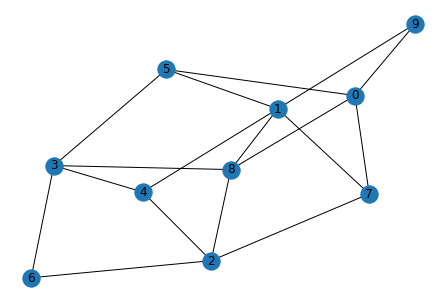

n=12,p=0.7,m=22,delta=2.0, Delta=6.0
a(phi): 0.025 | b(phi): 0.977 | chromatic number: 2

Bipartite chromatic bound: 0.093 | 2mn*a(phi): 0.093 | lambda_1 = 0.042
Bipartite chromatic bound: 3.137 | 2mn*b(phi): 3.581 | lambda_1 = 0.042



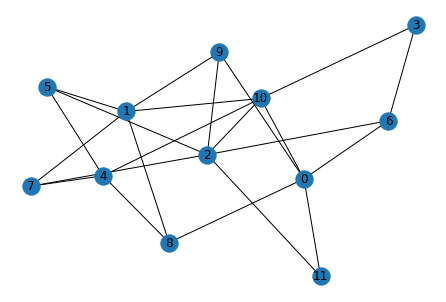

n=14,p=0.7,m=31,delta=2.0, Delta=6.0
a(phi): 0.018 | b(phi): 0.991 | chromatic number: 2

Bipartite chromatic bound: 0.078 | 2mn*a(phi): 0.078 | lambda_1 = 0.050
Bipartite chromatic bound: 3.874 | 2mn*b(phi): 4.388 | lambda_1 = 0.050



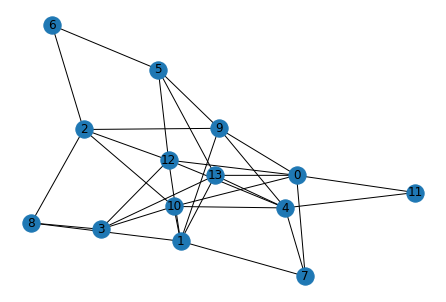

In [45]:
def generate_bipartite_graph(n1,n2,p, lap_type,seed):
    np.random.seed(seed)

    n = n1+n2
    G = nx.bipartite.random_graph(n1,n2,p, seed = 0) 

    
    #edges
    edges = defaultdict(list)
    [edges[i].append(j) for i,j in G.edges()]

    # generate random gains of unit modulus
    gains = np.exp(1j*np.random.rand(n,n))

    # adjacency matrix for the underlying graph
    Adj = nx.to_numpy_array(G)

    # calculate degree diagonal matrix
    D_vec = np.sum(Adj,1)
    D = np.diag(np.sum(Adj,1))
    delta, Delta = np.min(D_vec),np.max(D_vec)
    
    #no of edges
    m = G.number_of_edges()
    
    #signless lapalcian
    Q = D+Adj
    
    #signless normalized lapalcian
    Q_norm = np.identity(n) + np.diag(D_vec**(-.5))@Adj@np.diag(D_vec**(-.5))

    # adjacency matrix for the gain graph
    temp = np.multiply(gains,Adj)
    temp = (temp+temp.conj().T)
    abs_mat = np.absolute(temp)
    abs_mat = np.where(abs_mat==0,1,abs_mat)
    gain_Adj = temp/abs_mat
    
    # Laplacian matrix for the gain graph
    if lap_type == 'laplacian':
        return G, m, D,delta, Delta, gain_Adj, D - gain_Adj,Q,edges
    if lap_type == 'norm-laplacian':
        return G, m, D,delta, Delta, gain_Adj, (np.identity(n) - np.diag(D_vec**(-.5))@gain_Adj@np.diag(D_vec**(-.5))),Q_norm,edges
    
    
# ************************************************************************************
# np.random.seed(0)
# p_list = np.random.rand(3)
for n1 in range(4,7):
    n = 2*n1+2
    G, m, D,delta, Delta, gain_Adj, L,Q,edges = generate_bipartite_graph(n1,n1+2,0.7, 'laplacian',seed=0)
    
    igain_adj = np.conjugate(np.triu(-1j*gain_Adj)).T+np.triu(-1j*gain_Adj)
    L_b  = D-igain_adj
    eig, eigv = np.linalg.eigh(L)
    eig_b, eigv_b = np.linalg.eigh(L_b)
#     print(eig,eig_b)
#     print(igain_adj-gain_Adj,end='\n\n')
#     print(np.linalg.eigvals(L_b)-np.linalg.eigvals(L))
    
    print(f'n={n},p={0.7},m={m},delta={delta}, Delta={Delta}')
    a_phi,b_phi,chi = a_b_Phi(gain_Adj,'real'),a_b_Phi(gain_Adj,'img'),chrom_num(G)
    print(f'a(phi): {a_phi:.3f} | b(phi): {b_phi:.3f} | chromatic number: {chi}',end='\n\n')
    
    
    #Bipartite chromatic bound a(phi) 
    bound_a_phi = (m/(2*n1*(n1+2)))*(n-np.sqrt(n**2-4*a_phi*(2-a_phi)*n1*(n1+2)))
    #Bipartite chromatic bound b(phi)
    bound_b_phi = (m/(2*n1*(n1+2)))*(n-np.sqrt(n**2-4*b_phi*(2-b_phi)*n1*(n1+2)))
    print(f'Bipartite chromatic bound: {bound_a_phi:.3f} | 2mn*a(phi): {(2*m/n)*a_phi:.3f} | lambda_1 = {np.min(eig):.3f}')
    print(f'Bipartite chromatic bound: {bound_b_phi:.3f} | 2mn*b(phi): {(2*m/n)*b_phi:.3f} | lambda_1 = {np.min(eig):.3f}',end='\n\n')
    
#     theta = np.array([round(np.angle(gain_Adj[i][j]),3) if gain_Adj[i][j]!=0 else 0 for i in range(n) for j in range(n)]).reshape(n,n)
#     G = nx.from_numpy_matrix(theta)
    nx.draw(G,pos=nx.spring_layout(G),with_labels = True,fontsize = 30)
    #  -----------------------------------------------------------------
    plt.savefig(f'bipartite/{n}.eps',format='eps',dps=200)
    #  -----------------------------------------------------------------
    plt.show()

### Bipartite bound for the bipartite adjacency matrix defined in the paper

In [17]:
A = np.array([[1 ,-1 ,1 ,1, 1, 1, -1, -1, -1, -1, 1, 1, 1, 1, 1],
[1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1],
[1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1],
[1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1],
[1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, -1]])

# G=nx.from_numpy_matrix(np.abs(Adj))
# nx.draw(G,pos=nx.spring_layout(G),with_labels = True,fontsize = 30)

Adj = np.block([
    [np.zeros((5,5)),   A],
    [A.T, np.zeros((15,15))]])

D_vec = np.sum(np.abs(Adj), axis=1)
Delta = max(D_vec)

L = np.diag(D_vec)- Adj
eig, _ = np.linalg.eigh(L)
# print(f'lambda_1 = {eig[0]}, Bipartite bound = {bound_a_phi}')

n, n1, n2, m = 20, 5, 15, np.sum(D_vec)/2


a_phi = (1-(np.ones(n).T@Adj@np.ones(n))/(2*m))
m_n_a_phi = (2*m/n)*a_phi
bound_a_phi = (m/(2*n1*n2))*(n-np.sqrt(n**2-4*a_phi*(2-a_phi)*n1*(n2)))
print(f'lambda_1 = {eig[0]:.3f}, Bipartite bound = {bound_a_phi:.3f}, m_n_a_phi = {m_n_a_phi:.3f}, a_phi = {a_phi:.3f}')

# frustration bound
# frus_bound = n*np.sqrt(bound_a_phi*Delta)

lambda_1 = 3.597, Bipartite bound = 3.982, m_n_a_phi = 4.600, a_phi = 0.613


# Supplementary: An Analysis of Gershgorian Bounds

Lambda_n = 5.0


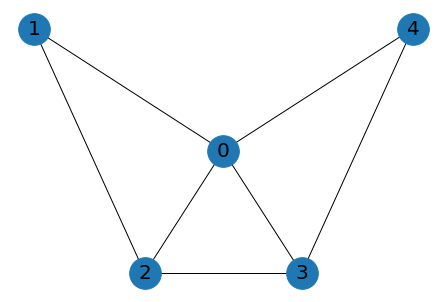

In [43]:
from networkx.generators import star_graph

n = 5
# G = star_graph(n-1)
G = cycle_graph(n)

# graph = 'star'
graph = 'wheel'

G.add_edge(0, 2)
G.add_edge(0, 3)
# G.add_edge(1, 3)

# n = 7
# G = erdos_renyi_graph(n, p_list[1],seed=n)

# adjacency matrix for the underlying graph
Adj = nx.to_numpy_array(G)

# calculate degree diagonal matrix
D_vec = np.sum(Adj,1)
D = np.diag(np.sum(Adj,1))

# Laplacian matrix for the gain graph
L = D - Adj

edges = defaultdict(list)
[edges[i].append(j) for i,j in G.edges()]
# edges


eig, eigv = np.linalg.eigh(L)
lambda_n = np.max(eig)
print(f'Lambda_n = {lambda_n}')

import matplotlib.pyplot as plt
%matplotlib inline

nx.draw(G,pos = nx.spectral_layout(G), node_size = 1000, with_labels = True, font_size=20)

#  -----------------------------------------------------------------
plt.savefig(f'{graph}.eps',format='eps',dps=200)
#  -----------------------------------------------------------------

## Unfolding the recurrence relation for gershgorian bounds

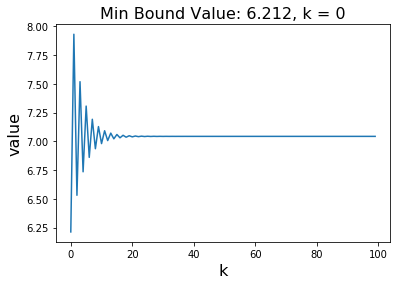

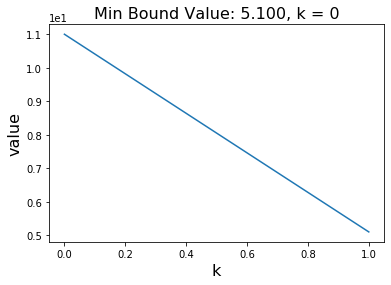

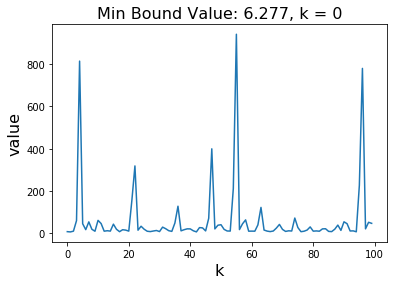

In [44]:
ind,m_min,bounds_m = d_m_power_k(D,n, L,iterations=100)
plt.plot(list(range(100)),bounds_m)
plt.xlabel('k',fontsize=16)
plt.ylabel('value',fontsize=16)
plt.title(f'Min Bound Value: {m_min:.3f}, k = {ind}',fontsize=16)
#  -----------------------------------------------------------------
# plt.savefig(f'm_k_{graph}.eps',format='eps',dps=200)
#  -----------------------------------------------------------------
plt.show()

_,n_min,bounds_n = d_n_power_k(D,n, L,iterations=100)
plt.plot(list(range(100)),bounds_n)
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('k',fontsize=16)
plt.ylabel('value',fontsize=16)
plt.title(f'Min Bound Value: {n_min:.3f}, k = {ind}',fontsize=16)
#  -----------------------------------------------------------------
# plt.savefig(f'n_k_{graph}.eps',format='eps',dps=200)
#  -----------------------------------------------------------------
plt.show()

_,l_min,bounds_l = d_l_power_k(D,n,Adj,L,iterations=100)
plt.plot(list(range(100)),bounds_l)
plt.xlabel('k',fontsize=16)
plt.ylabel('value',fontsize=16)
plt.title(f'Min Bound Value: {l_min:.3f}, k = {ind}',fontsize=16)
#  -----------------------------------------------------------------
# plt.savefig(f'l_k_{graph}.eps',format='eps',dps=200)
#  -----------------------------------------------------------------
plt.show()

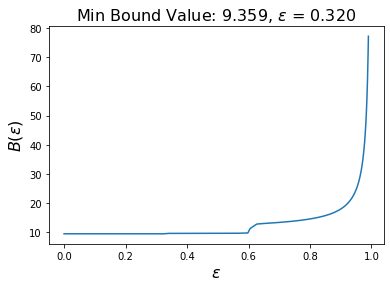

In [31]:
# epsilons = np.linspace(-2,10,100) #1.218
# epsilons = np.linspace(5.9,6,1000) #1.218
# epsilons = np.linspace(0,1.218,400) #1.218
epsilons = np.linspace(0,0.99,1000) #1.218
# ***********************************************************************************
def d_n_power_k_epsilon(D,n,L,iterations):
    bounds = []
#     epsilons = 0.2*np.ones(10)
    jn = np.ones(n)
    orig = D
    for epsilon in epsilons:
        min_k,ind = np.inf,0
        D = orig
        for k in range(iterations):
            D_vec = np.diagonal(D)-epsilon*np.ones(n)
            Ah = np.abs((np.diag(D_vec**(-1)))@(np.abs(L))@(np.diag(D_vec)))
            d = Ah@jn
            bound = max(d)
            D = np.diag(d)

            if  bound <= min_k:
                    min_k = bound
                    ind = k
        bounds.append(min_k)
    bounds = np.array(bounds)
    return epsilons[bounds == np.min(bounds)][0], bounds
# d_n_power_k(D,n,L,iterations=100)


k, bounds_n = d_n_power_k_epsilon(D,n, L,iterations=100)
plt.plot(epsilons,bounds_n)
plt.xlabel(r'$\epsilon$',fontsize = 16)
plt.ylabel(r'$B(\epsilon)$',fontsize = 16)
plt.title(f'Min Bound Value: {min(bounds_n):.3f}, $\epsilon$ = {k:.3f}',fontsize=16)
#  -----------------------------------------------------------------
plt.savefig(f'n_k_epsilon-{graph}.eps',format='eps',dps=200)
#  -----------------------------------------------------------------
plt.show()

### $\eta$ analysis for $m^k$ bound

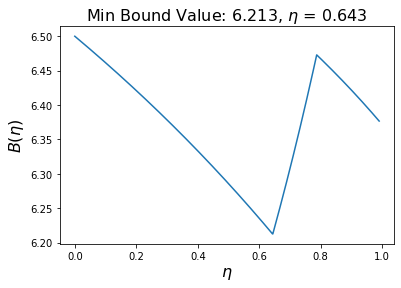

In [8]:
etas = np.linspace(0,0.99,1000) #1.218
# ***********************************************************************************
def d_m_power_k_eta(D,n,L,iterations):
    bounds = []
    orig = D
    jn = np.ones(n)
    
    for eta in etas:
        min_k,ind = np.inf,0
        
        D = orig
        #delta = np.min(np.diagonal(D))
        D = D-eta*np.identity(n)
        #D = 2*(np.max(D)+1)*np.identity(n)
        
        for k in range(iterations):
            D_vec = np.diagonal(D)
            Ah = np.abs((np.diag(D_vec**(-1)))@np.abs(L)@(np.diag(D_vec)))
            d = Ah@jn
            bound = max(d)
            D = np.diag(d)

            if  bound <= min_k:
                    min_k = bound
                    ind = k
        bounds.append(min_k)
    bounds = np.array(bounds)
    return etas[bounds == np.min(bounds)][0], bounds


k, bounds_n = d_m_power_k_eta(D,n, L,iterations=100)
plt.plot(etas,bounds_n)
plt.xlabel(r'$\eta$',fontsize = 16)
plt.ylabel(r'$B(\eta)$',fontsize = 16)
plt.title(f'Min Bound Value: {min(bounds_n):.3f}, $\eta$ = {k:.3f}',fontsize=16)
#  -----------------------------------------------------------------
plt.savefig(f'm_k_eta-{graph}.eps',format='eps',dps=200)
#  -----------------------------------------------------------------
plt.show()